<a href="https://colab.research.google.com/github/shishir-joshi/notebooks/blob/master/ULMFiT_MultiLabel_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

1. https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d

2. https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79

3. https://medium.com/dair-ai/a-simple-neural-network-from-scratch-with-pytorch-and-google-colab-c7f3830618e0

4. https://colab.research.google.com/drive/1gCgtlnMPVWY0l1ra8ssS0EzJiWaVR4Pk

5. !!
https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

6. !!
https://docs.fast.ai/basic_data.html#DataBunch

7. !!
https://docs.fast.ai/text.html

8. !!
https://www.aclweb.org/anthology/C18-1330/

9. !!
https://forums.fast.ai/t/a-quick-and-easy-way-to-make-ulmfit-work-for-multi-label-problems/17222

10. !!
https://docs.fast.ai/text.learner.html#text.learner

11. !!
https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb


# Trying out ULMFiT

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
# !pip install tensorflow-gpu==2.0.0b1

import matplotlib.pyplot as plt
import pandas as pd
# BeautifulSoup is useful for parsing HTML and XML tags
from bs4 import BeautifulSoup
# NLTK is the NLP library
from nltk.corpus import stopwords
# Regular Expressions useful for quickly searching corpus of text
import re
import string
# from tensorflow import keras
import tarfile
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
from random import shuffle
# from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
torch.backends.cudnn.enabled

True

In [0]:
torch.cuda.is_available()

True

### Download/ Prepare/ Preprocess Dataset

In [0]:
!git clone https://github.com/Jaspereclipse/kaggle-transfer-learning-on-stack-exchange-tags

Cloning into 'kaggle-transfer-learning-on-stack-exchange-tags'...
remote: Enumerating objects: 179, done.
remote: Total 179 (delta 0), reused 0 (delta 0), pack-reused 179
Receiving objects: 100% (179/179), 52.91 MiB | 17.47 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [0]:
train_dir = !ls */*/train/*
test_dir = !ls */*/test/*
print(test_dir)
print(train_dir)
train_df = []
for c in train_dir:
  train_df.append(pd.read_csv(c))
for tdf in train_df:
  tdf["text"] = tdf["title"]+tdf["content"]
  tdf.pop("id")
  tdf.pop("title")
  tdf.pop("content")
test_df = []
for c in test_dir:
  test_df.append(pd.read_csv(c))
for tdf in test_df:
  tdf["text"] = tdf["title"]+tdf["content"]
  tdf.pop("id")
  tdf.pop("title")
  tdf.pop("content")

['kaggle-transfer-learning-on-stack-exchange-tags/data/test/test.csv']
['kaggle-transfer-learning-on-stack-exchange-tags/data/train/biology.csv', 'kaggle-transfer-learning-on-stack-exchange-tags/data/train/cooking.csv', 'kaggle-transfer-learning-on-stack-exchange-tags/data/train/crypto.csv', 'kaggle-transfer-learning-on-stack-exchange-tags/data/train/diy.csv', 'kaggle-transfer-learning-on-stack-exchange-tags/data/train/robotics.csv', 'kaggle-transfer-learning-on-stack-exchange-tags/data/train/travel.csv']


In [0]:
train_df[1].head()

,tags,text
0,baking cookies texture,How can I get chewy chocolate chip cookies?<p>...
1,oven cooking-time bacon,How should I cook bacon in an oven?<p>I've hea...
2,eggs,What is the difference between white and brown...
3,substitutions please-remove-this-tag baking-so...,What is the difference between baking soda and...
4,sauce pasta tomatoes italian-cuisine,"In a tomato sauce recipe, how can I cut the ac..."


#### Cleaning the data

In [0]:
uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 100000000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 400

# Mapping function to strip the CSVs of html tags and all
def stripTagsAndUris(x):
  if x:
      # BeautifulSoup on content
      soup = BeautifulSoup(x, "html.parser")
      # Stripping all <code> tags with their content if any
      if soup.code:
          soup.code.decompose()
      # Get all the text out of the html
      text =  soup.get_text()
      # Returning text stripping out all uris
      return re.sub(uri_re, "", text)
  else:
      return ""
      
def removePunctuation(x):
    # Lowercasing all words
  x = x.lower()
  # Removing non ASCII chars
  x = re.sub(r'[^\x00-\x7f]',r' ',x)
  # Removing (replacing with empty spaces actually) all the punctuations
  return re.sub("["+string.punctuation+"]", " ", x)


  
for tdf in train_df:
  tdf["text"] = tdf["text"].apply(stripTagsAndUris)
  tdf["text"] = tdf["text"].apply(removePunctuation)

  
for tdf in test_df:
  tdf["text"] = tdf["text"].apply(stripTagsAndUris)
  tdf["text"] = tdf["text"].apply(removePunctuation)
# Unrolling 
train_df = pd.concat(train_df)
test_df = pd.concat(test_df)

# Sampling the dataset for experimentation
train_df = train_df.sample(900)

In [0]:
_, val_df =train_test_split(train_df, test_size=0.2)

In [0]:
train_df

,tags,text
11974,repair lawn-mower,how can i remove this stuck nut on my riding m...
4185,evolution sociality,evolution of bee hiveshow do the instinct to c...
14158,meat turkey fats,does 85 lean ground turkey have the same amou...
6021,wine,wine selection when dining on horse meat i kno...
12518,winterizing,why is the pressure vacuum breaker leaking whi...
...,...,...
918,homomorphic-encryption,is there difference between algebraic homomorp...
1533,japan hotels mail,can you receive mail at hotels weeks before yo...
5238,doors installation,how do i hang a prehung door i want to put up ...
1899,baking bread,baking bread without crust my fiancee does...


### Getting Data Ready for ULMFit

#### First fit ULMFiT on the dataset

In [0]:
lang_model = TextLMDataBunch.from_df(path='/content/ULMFit', train_df=train_df, valid_df=val_df)

In [0]:
lang_model.show_batch()

idx,text
0,seen suggestions on heating the nut but i do not have an xxunk torch handy so i m looking for good advise i am familiar with some of the more obvious techniques such as what s proposed here how to xxunk a nut when bolt and nut move together \n any advise \n \n xxbos evolution of xxunk xxunk do the xxunk to create a hive appeared in
1,muscular pieces in the muscular string fiber contract when the fiber contracts if not does that mean the number of the xxunk muscular pieces xxunk to the angle of my joint \n xxbos can someone bring a packed phone from us to xxunk of my friend is coming to india from us he bought himself a laptop and a camera which he is using their also i xxunk him
2,they contain xxunk i can t find anything in wikipedia about this \n xxbos how to make xxunk powder for candy when i was young someone taught me how to make this powder you find on candy it s acidic and seems to xxunk in the mouth but i don t know the name and so i can t find a recipe \n i suppose i need to
3,of subway tiles so i could replace them with custom cut tiles that would fit without a gap \n xxbos is it okay to put a hot pan on a granite counter is it okay to put a hot pan pot on a granite counter or will it burn it i don t know if there s a sealer on it \n xxbos how to generate many passwords
4,floor framing using joist hangers i have a single story ranch where a corner of the house i believe was a car port the roof line and walls all are framed such that it was always under the roof and considered part of the house however i believe somewhere along the line someone xxunk it up and made a living space out of it they did not raise the floor


In [0]:
# Initialize the learner
learner = language_model_learner(lang_model, AWD_LSTM, drop_mult=0.5)

learner.unfreeze()

In [0]:
learner.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.413590,5.112805,0.171875,00:11
1,5.195516,4.817350,0.197842,00:11
2,4.981871,4.514236,0.227121,00:11
3,4.774595,4.198309,0.257924,00:11
4,4.551726,3.831174,0.298214,00:11
5,4.296237,3.465342,0.349888,00:11
6,4.008378,3.083539,0.409189,00:11
7,3.722802,2.744548,0.466518,00:11
8,3.432054,2.439039,0.522582,00:11
9,3.163834,2.225070,0.562500,00:11


In [0]:
# Checking 
learner.predict("im trying to make an ", n_words=10)

'im trying to make an  identification search advances indian dhabi passports and external embassies weren'

In [0]:
learner.save_encoder('ulmfit_enc')

#### The MultiLabel Classifier layer
 

In [0]:
classifier = TextClasDataBunch.from_df(path='/content/ULMFit', train_df=train_df, valid_df=val_df, vocab=lang_model.train_ds.vocab, bs=32)

Full Disclosure : the following class block has been picked up from ref no. 9 but subsequently I learned that the text_classifier_learner function automatically adapts the final layer for multilabel classification so it hasn't been used 

In [0]:
class MultiLabelClassifier(nn.Module):
    
    def __init__(self, y_range=None):
        super().__init__()
        self.y_range = y_range
    
    def forward(self, input):
        x, raw_outputs, outputs = input
        x = F.sigmoid(x)
        if (self.y_range):
            x = x * (self.y_range[1] - self.y_range[0])
            x = x + self.y_range[0]
        
        return x, raw_outputs, outputs
# del classifier
# torch.cuda.empty_cache()

# classifier_learn.loss_func.func = F.binary_cross_entropy_with_logits
# classifier_learn.summary
# classifier_learn.crit = F.binary_cross_entropy_with_logits
# classifier_learn.model.add_module('2', MultiLabelClassifier())

In [0]:
classifier_learner = text_classifier_learner(classifier, AWD_LSTM, drop_mult=0.5)
classifier_learner.load_encoder('ulmfit_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (900 items)
x: TextList
xxbos how can i remove this stuck nut on my riding mower i am attempting to repair a shattered housing xxunk on my xxunk riding mower i have it xxunk disassembled however i am facing a common problem a stuck nut on a piece that is moving the only leverage i can get is with the tool on the nut and the blade below i have done some reading and seen suggestions on heating the nut but i do not have an xxunk torch handy so i m looking for good advise i am familiar with some of the more obvious techniques such as what s proposed here how to xxunk a nut when bolt and nut move together 
  any advise 
 
 ,xxbos evolution of xxunk xxunk do the xxunk to create a hive appeared in xxunk is there some evidence of 
  intermediate xxunk with this questions i mean all the factors necessary to build a hive including the social structure the producing of xxunk and architecture 
 ,xxbos does 85 lean ground turkey have the same amo

In [0]:
classifier_learner.unfreeze()

In [0]:
classifier_learner.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.918379,6.763258,0.000000,00:21
1,6.862895,6.519504,0.011111,00:20
2,6.707651,6.140455,0.033333,00:22
3,6.542593,5.684774,0.166667,00:23
4,6.315500,5.262594,0.361111,00:23
5,6.031075,5.003117,0.511111,00:20
6,5.755956,4.395498,0.794444,00:23
7,5.431633,4.062148,0.888889,00:21
8,5.127717,3.770995,0.927778,00:21
9,4.843207,3.493947,0.955556,00:21


In [0]:
# torch.cuda.empty_cache

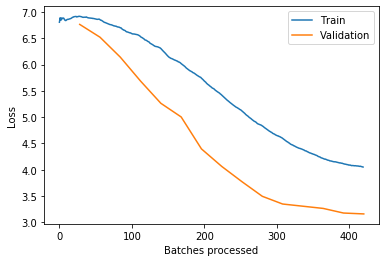

In [0]:
classifier_learner.recorder.plot_losses()

#### Outputs

In [0]:
classifier_learner.save('/content/multi_label_learner_v1')


In [0]:
classifier_learner.export()

##### On Val set

In [0]:
# Some random sample 
ind = np.random.randint(low=0,high=180)
text, categories = classifier_learner.data.valid_ds[ind]
print("Input :",text)
print("Categories :",categories)

Input : xxbos real time simulation model of sensors with xxunk am trying to make a real time simulink model of leddar sensor xxunk sensor xxunk kit in matlab using usb port but i can t use data xxunk toolbox and xxunk control toolbox because the leddar vendor isn t listed in these xxunk i would really appreciate if someone could help me with this because i am new to real time simulink 
 
Categories : sensors matlab simulator real-time


In [0]:
# Pass it to trained model

p = classifier_learner.predict(text)

In [0]:
p[0]

Category sensors matlab simulator real-time

In [0]:
import matplotlib.cm as cm

txt_ci = TextClassificationInterpretation.from_learner(classifier_learner)
test_text = text
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


##### rough On Training set:

In [0]:
preds, _ = classifier_learner.get_preds(ds_type=DatasetType.Train)

In [0]:
# np.argmax(preds, axis=0)
preds

tensor([[0.0013, 0.0012, 0.0019,  ..., 0.0004, 0.0012, 0.0011],
        [0.0014, 0.0008, 0.0021,  ..., 0.0013, 0.0004, 0.0011],
        [0.0027, 0.0020, 0.0011,  ..., 0.0008, 0.0003, 0.0046],
        ...,
        [0.0008, 0.0006, 0.0015,  ..., 0.0012, 0.0019, 0.0010],
        [0.0007, 0.0008, 0.0009,  ..., 0.0004, 0.0009, 0.0004],
        [0.0015, 0.0006, 0.0014,  ..., 0.0004, 0.0006, 0.0013]])

In [0]:
# np.argmax(preds, axis=1)
preds.max()

np.average(preds.numpy())

0.0011862396

In [0]:
thresh = (0.02)
labelled_preds = [' '.join([classifier_learner.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
classifier_learner.data.train_ds

LabelList (900 items)
x: TextList
xxbos getting a tourist schengen visa after working xxunk s my situation i am currently in france on an internship visa different than a business and tourist visa which ends next month i m interested in doing some traveling afterwards ideally on a 90 day schengen tourist visa i m willing to hop over to a non schengen country like the uk for a couple days and then come back to get the tourist visa if necessary 
  this post seems similar to my question except the xxunk is trying to get the tourist visa without leaving the schengen area 
  is this allowed will the border xxunk still give me the tourist visa after my internship visa expires will it work through the uk or should i go through another non schengen country i have a usa passport 
 ,xxbos hashing entropy with only 128 bits of internal xxunk am looking to implement the xxunk algorithm on a system with very xxunk memory constraints using aes 128 as the underlying cipher 
  as the key size is only 

In [0]:
labelled_preds

['',
 'windows installation fitting',
 'slam',
 'uk legal hotels fees-and-charges',
 'hash zero-knowledge-proofs',
 'public-transport airport-transfer slovenia ljubljana',
 'yeast sourdough-starter',
 '',
 'electrical code-compliance generator',
 '',
 'plaster anchor',
 '',
 'freezing microwave convenience-foods',
 '',
 '',
 'electrical',
 'proteins mrna',
 'brushless-motor encoding hall-sensor',
 '',
 '',
 'budget europe interrail',
 'mac poly1305 modular-arithmetic',
 'refrigerator',
 '',
 'insulation ventilation',
 'sha-256 brute-force-attack rainbow-table',
 'budget netherlands amsterdam belgium brussels',
 '',
 'mechanism',
 'sensors accelerometer gps',
 '',
 'international-travel money bookings payment-cards',
 'repair heating ceiling radiant-heating',
 'wood furniture wooden-furniture sanding',
 'chicken salt slow-cooking poaching',
 '',
 'cleaning vent dryer ducts',
 'studs chimney lath-and-plaster',
 'hash implementation stream-cipher encryption salsa20',
 'plumbing water',
 '

In [0]:
len(labelled_preds)

896